<a href="https://colab.research.google.com/github/threedee003/NotebooksForDL/blob/main/usingBatchTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
trainDir = "/content/drive/MyDrive/GIS/trainTiles"
testDir = "/content/drive/MyDrive/GIS/testTiles"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io as io
import time
from itertools import product



import torch.nn as nn
import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [4]:

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.imageFilenames = sorted(os.listdir(os.path.join(data_dir, "tiles")))

    def __len__(self):
        return len(self.imageFilenames)

    def __getitem__(self, idx):
        imagePath = os.path.join(self.data_dir, "tiles", self.imageFilenames[idx])
        img = np.load(imagePath)
        X = img[:,:,0:5]
        Y = img[:,:,-1]


        

        if self.transform:
            X = self.transform(X)
            Y = self.transform(Y)

        return X, Y


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
trainSet = CustomDataset(trainDir, transform=transform)
validationSet = CustomDataset(testDir, transform=transform)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=4, shuffle=True)
validationLoader = torch.utils.data.DataLoader(validationSet, batch_size = 4, shuffle = True)

In [7]:
print("Number of training samples : {}".format(len(trainLoader)))
print("Number of validating samples : {}".format(len(validationLoader)))

Number of training samples : 280
Number of validating samples : 110


In [8]:
class Autoencoder1(nn.Module):
  def __init__(self,channels):
    super(Autoencoder1,self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(channels,64, kernel_size = 3),
        nn.Conv2d(64,64,kernel_size = 3, stride = 2),
        nn.Conv2d(64,128,kernel_size= 3),
        nn.Conv2d(128,128,kernel_size = 3,stride = 2),
        nn.Conv2d(128,256,kernel_size = 3),
        nn.Conv2d(256,256,kernel_size = 3,stride = 2),
        nn.Conv2d(256,512,kernel_size = 3)
    )

    self.decoder = nn.Sequential(
        nn.Conv2d(512,256,kernel_size = 2),
        nn.ConvTranspose2d(256,256,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(256,128,kernel_size = 3),
        nn.ConvTranspose2d(128,128,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(128,64,kernel_size = 3),
        nn.ConvTranspose2d(64,64,kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.Conv2d(64,1,kernel_size = 3)
    )


  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [9]:
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        
        # Decoder
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.conv6 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.conv8 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        
        # Decoder
        x = self.relu5(self.conv5(x))
        x = self.relu6(self.conv6(x))
        x = self.relu7(self.conv7(x))
        x = self.sigmoid(self.conv8(x))
        return x

In [11]:
autoenc = Autoencoder3()

In [12]:
summary(autoenc.to('cuda'),(5,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,472
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
   ConvTranspose2d-9          [-1, 128, 16, 16]         295,040
             ReLU-10          [-1, 128, 16, 16]               0
  ConvTranspose2d-11           [-1, 64, 32, 32]          73,792
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13           [-1, 32, 64, 64]          18,464
             ReLU-14           [-1, 32,

In [13]:

def trainer(model,trainLoader,validationLoader,epochs,lossFn,optimizer,trainLoss,validLoss,device,batchSize):
  print("Training has begun.....")
  startTime = time.time()
  model = model.to(device)
  for epoch in range(epochs):
    runningLoss = 0.0
    for x, y in trainLoader:
      x = x.to(device)
      y = y.to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss = lossFn(pred,y)
      loss.backward()
      optimizer.step()
      runningLoss += loss.item()
    trainLoss.append(runningLoss/(len(trainLoader)/batchSize))

    with torch.no_grad():
      valLoss = 0.0
      for x, y in validationLoader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = lossFn(pred,y)
        valLoss += loss.item()
      validLoss.append(valLoss/(len(validationLoader)/batchSize))

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {runningLoss/len(trainLoader)}, Validation Loss: {valLoss/len(validationLoader)}")
  print(f"Training is complete......")
  print("--- %s seconds ---" % (time.time() - startTime))










      


In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(autoenc.parameters(), lr=0.001)
batchSize = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 50
trainArr = []
validArr = []

In [15]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [17]:
trainer(autoenc,trainLoader,validationLoader,eps,criterion,optimizer,trainArr,validArr,device,batchSize)

Training has begun.....
Epoch 1/50, Training Loss: 0.3085255819343729, Validation Loss: 0.24396515845807948
Epoch 2/50, Training Loss: 0.24055690557054601, Validation Loss: 0.38259670021718856
Epoch 3/50, Training Loss: 0.22251306841923388, Validation Loss: 0.19339713508432563
Epoch 4/50, Training Loss: 0.2171321175364012, Validation Loss: 0.43861737214352947
Epoch 5/50, Training Loss: 0.21279036243943536, Validation Loss: 0.22081386058760638
Epoch 6/50, Training Loss: 0.196727819352444, Validation Loss: 0.16235325912394646
Epoch 7/50, Training Loss: 0.25095558335015083, Validation Loss: 0.15336246104402976
Epoch 8/50, Training Loss: 0.2046857627256811, Validation Loss: 0.15711762221022085
Epoch 9/50, Training Loss: 0.20962028608358066, Validation Loss: 0.16014425107701258
Epoch 10/50, Training Loss: 0.22691903975282912, Validation Loss: 0.16364553462375295
Epoch 11/50, Training Loss: 0.22300041730715228, Validation Loss: 0.15829104632139207
Epoch 12/50, Training Loss: 0.19355775835787

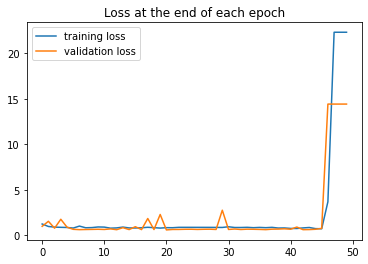

In [18]:

plt.plot(trainArr, label='training loss')
plt.plot(validArr, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();